# The task

Make predictions about the usefullness of a medicine kit for humans

- OBS.: ``Target``: 0 is usefull, 1 is not usefull

## Imports

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.compose import ColumnTransformer

In [2]:
df_train = pd.read_csv(filepath_or_buffer="../data/raw/train.csv")
df_test = pd.read_csv(filepath_or_buffer="../data/raw/test.csv")

In [3]:
df_train.head()

,ID,Distributor,Product,Duration,Destination,Sales,Commission,Gender,Age,Target
0,fffe3800370038003900,7,1,22,122,31.0,0.00,NaN,20,0
1,fffe34003200370037003500,7,1,26,52,22.0,0.00,NaN,36,0
2,fffe32003100320030003200,7,10,15,83,63.0,0.00,NaN,34,0
3,fffe34003400310037003000,8,25,24,55,62.0,24.80,0.0,118,0
4,fffe32003400390038003000,6,16,12,122,19.8,11.88,NaN,26,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6736 entries, 0 to 6735
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           6736 non-null   object 
 1   Distributor  6736 non-null   int64  
 2   Product      6736 non-null   int64  
 3   Duration     6736 non-null   int64  
 4   Destination  6736 non-null   int64  
 5   Sales        6736 non-null   float64
 6   Commission   6736 non-null   float64
 7   Gender       2032 non-null   float64
 8   Age          6736 non-null   int64  
 9   Target       6736 non-null   int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 526.4+ KB


In [5]:
df_test.head()

,ID,Distributor,Product,Duration,Destination,Sales,Commission,Gender,Age
0,fffe31003600330038003500,6,16,8,60,69.30,41.58,NaN,51
1,fffe33003600300031003400,2,4,368,112,161.00,40.25,0.0,51
2,fffe320033003300,2,4,387,112,291.75,72.94,0.0,51
3,fffe390039003800,7,10,4,25,18.00,0.00,NaN,36
4,fffe3500350031003000,11,20,40,59,39.50,25.68,0.0,38


In [6]:
# Looking for missing values
df_train.isna().sum()

ID                0
Distributor       0
Product           0
Duration          0
Destination       0
Sales             0
Commission        0
Gender         4704
Age               0
Target            0
dtype: int64

In [7]:
# Lookingo for duplicated entries
df_train.duplicated().sum()

np.int64(0)

<Axes: xlabel='Target', ylabel='count'>

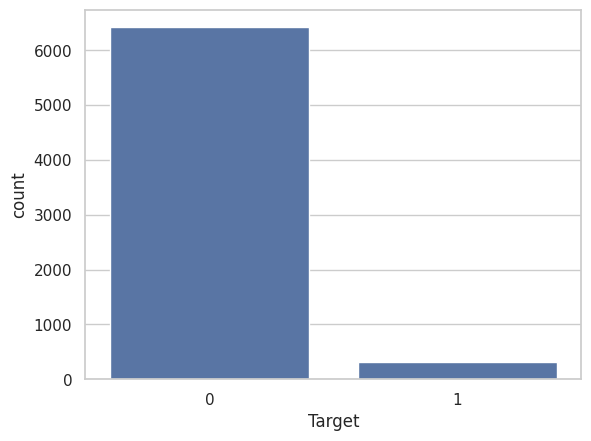

In [8]:
# Target distribution
sns.countplot(data=df_train, x=df_train["Target"])

In [9]:
df_train["Target"].value_counts(normalize=True)

Target
0    0.953088
1    0.046912
Name: proportion, dtype: float64

In [10]:
# Descriptive statistics
df_train.describe()

# Max Age value is strange
# Min Sales negative?
# Min Duration negative?

,Distributor,Product,Duration,Destination,Sales,Commission,Gender,Age,Target
count,6736.000000,6736.00000,6736.000000,6736.000000,6736.000000,6736.000000,2032.000000,6736.000000,6736.000000
mean,6.563539,9.40380,51.588034,81.681413,42.802316,10.469831,0.512795,39.880344,0.046912
std,2.440587,6.62581,79.504738,39.530726,52.408053,20.342999,0.499959,13.872811,0.211466
min,0.000000,0.00000,-1.000000,0.000000,-277.200000,0.000000,0.000000,1.000000,0.000000
25%,6.000000,2.00000,10.000000,55.000000,18.000000,0.000000,0.000000,35.000000,0.000000
50%,7.000000,10.00000,23.000000,86.000000,28.000000,0.000000,1.000000,36.000000,0.000000
75%,7.000000,16.00000,54.000000,112.000000,49.500000,11.880000,1.000000,44.000000,0.000000
max,15.000000,25.00000,444.000000,139.000000,666.000000,262.760000,1.000000,118.000000,1.000000


<Axes: xlabel='Age'>

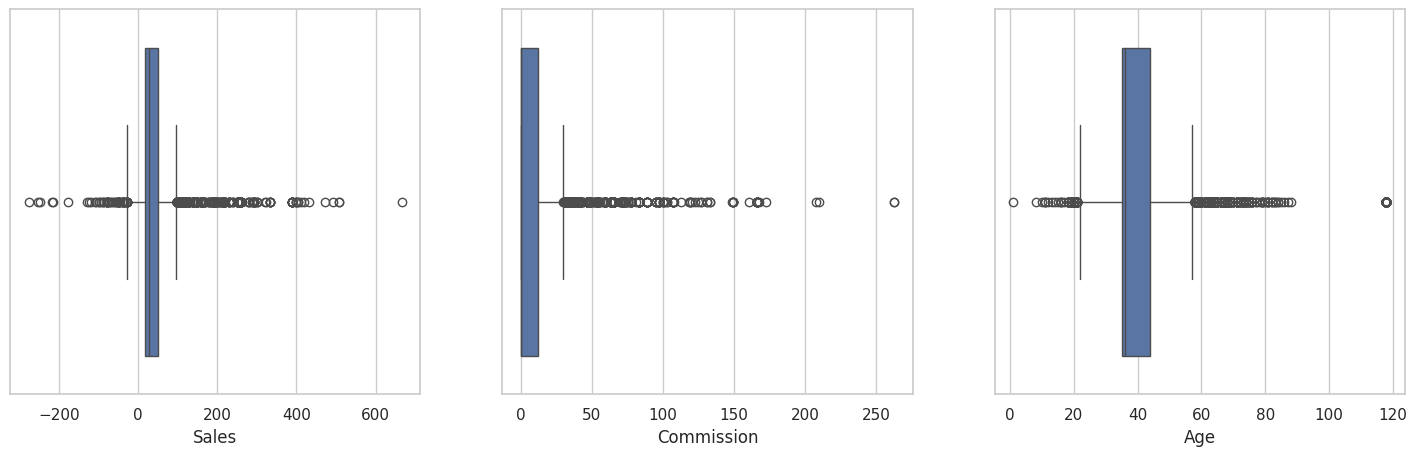

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
sns.boxplot(data=df_train, x=df_train["Sales"], ax=ax[0])
sns.boxplot(data=df_train, x=df_train["Commission"], ax=ax[1])
sns.boxplot(data=df_train, x=df_train["Age"], ax=ax[2])

In [12]:
df_train[df_train["Age"] > 100]["Age"].unique()

array([118])

In [13]:
# Remove coluns with Age = 118
df_train = df_train[df_train["Age"] != 118]

In [14]:
df_train[df_train["Age"] > 100]

,ID,Distributor,Product,Duration,Destination,Sales,Commission,Gender,Age,Target


In [15]:
# Negative Sales
df_train[df_train["Sales"] < 0]

,ID,Distributor,Product,Duration,Destination,Sales,Commission,Gender,Age,Target
12,fffe34003100300038003100,6,16,35,78,-19.80,11.88,NaN,37,0
40,fffe34003400340035003200,6,16,27,4,-79.20,47.52,NaN,34,0
58,fffe3100300030003300,6,16,65,60,-79.20,47.52,NaN,45,0
68,fffe32003500320037003400,2,17,309,112,-53.25,13.31,1.0,37,0
250,fffe31003400300038003800,2,9,5,112,-13.50,3.38,0.0,31,0
...,...,...,...,...,...,...,...,...,...,...
5982,fffe31003800390031003600,6,16,166,112,-29.70,17.82,NaN,31,0
6240,fffe32003900330037003000,6,16,12,4,-89.10,53.46,NaN,59,0
6394,fffe32003200300030003800,6,16,75,58,-29.70,17.82,NaN,32,0
6425,fffe33003700320039003000,6,16,25,4,-79.20,47.52,NaN,61,0


In [16]:
# Remove negative Sales
df_train = df_train[df_train["Sales"] > 0]

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6365 entries, 0 to 6735
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           6365 non-null   object 
 1   Distributor  6365 non-null   int64  
 2   Product      6365 non-null   int64  
 3   Duration     6365 non-null   int64  
 4   Destination  6365 non-null   int64  
 5   Sales        6365 non-null   float64
 6   Commission   6365 non-null   float64
 7   Gender       1895 non-null   float64
 8   Age          6365 non-null   int64  
 9   Target       6365 non-null   int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 547.0+ KB


In [18]:
# Spliting df_train into X and y(target)
X_train = df_train.drop(columns="Target")
y_train = df_train["Target"].copy()

In [19]:
# Split into train and validation dataframes
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [21]:
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))

Target
0    0.9511
1    0.0489
Name: proportion, dtype: float64
Target
0    0.951296
1    0.048704
Name: proportion, dtype: float64


In [22]:
# Selected features ==> Gender will not be used as a predictive feature for two reasons: a) ethics; b) most of the values are NaN
features = X_train.columns.drop(["ID", "Gender"])
features

Index(['Distributor', 'Product', 'Duration', 'Destination', 'Sales',
       'Commission', 'Age'],
      dtype='object')

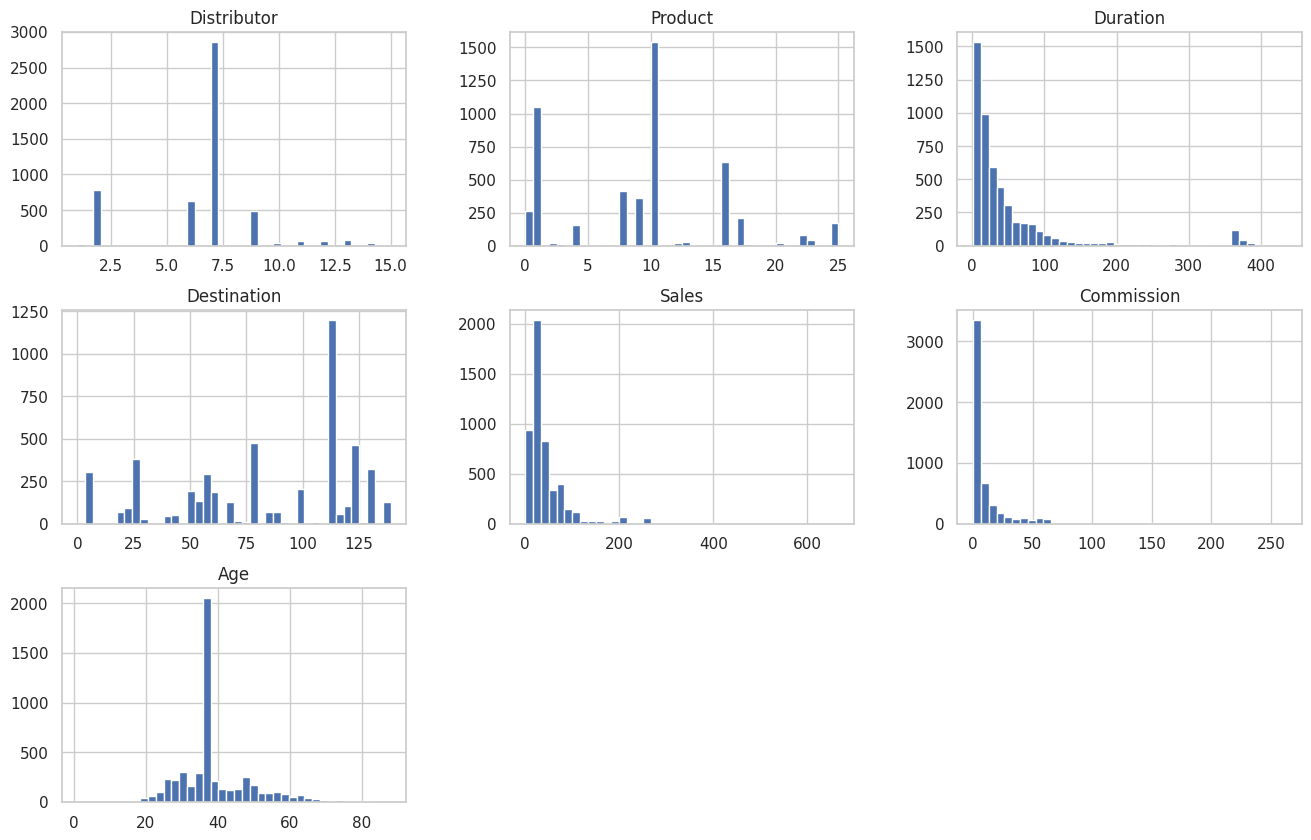

In [23]:
X_train[features].hist(bins=40, figsize=(16,10));

## Model training

<Axes: >

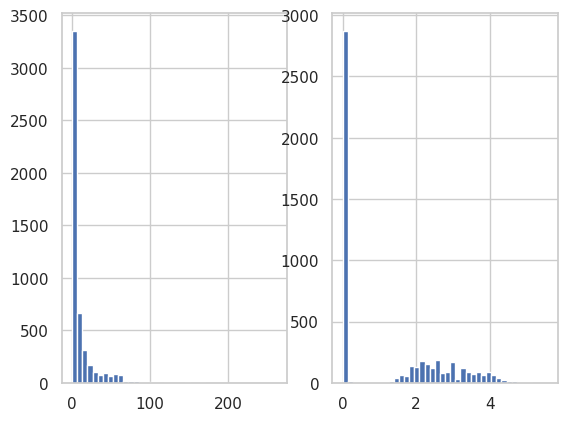

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2)
X_train["Commission"].hist(bins=40, ax=ax[0])
X_train["Commission"].transform(np.log1p).hist(bins=40, ax=ax[1])

In [24]:
std_scaler = StandardScaler()
X_train_resc = std_scaler.fit_transform(X_train[features])

In [25]:
# Pipeline
clf = Pipeline([
    ("std_scaler", StandardScaler()),
    ("model", RandomForestClassifier(random_state=42))
])

In [26]:
clf.fit(X=X_train[features], y=y_train)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model', RandomForestClassifier(random_state=42))])

In [36]:
clf.named_steps["std_scaler"]

StandardScaler()

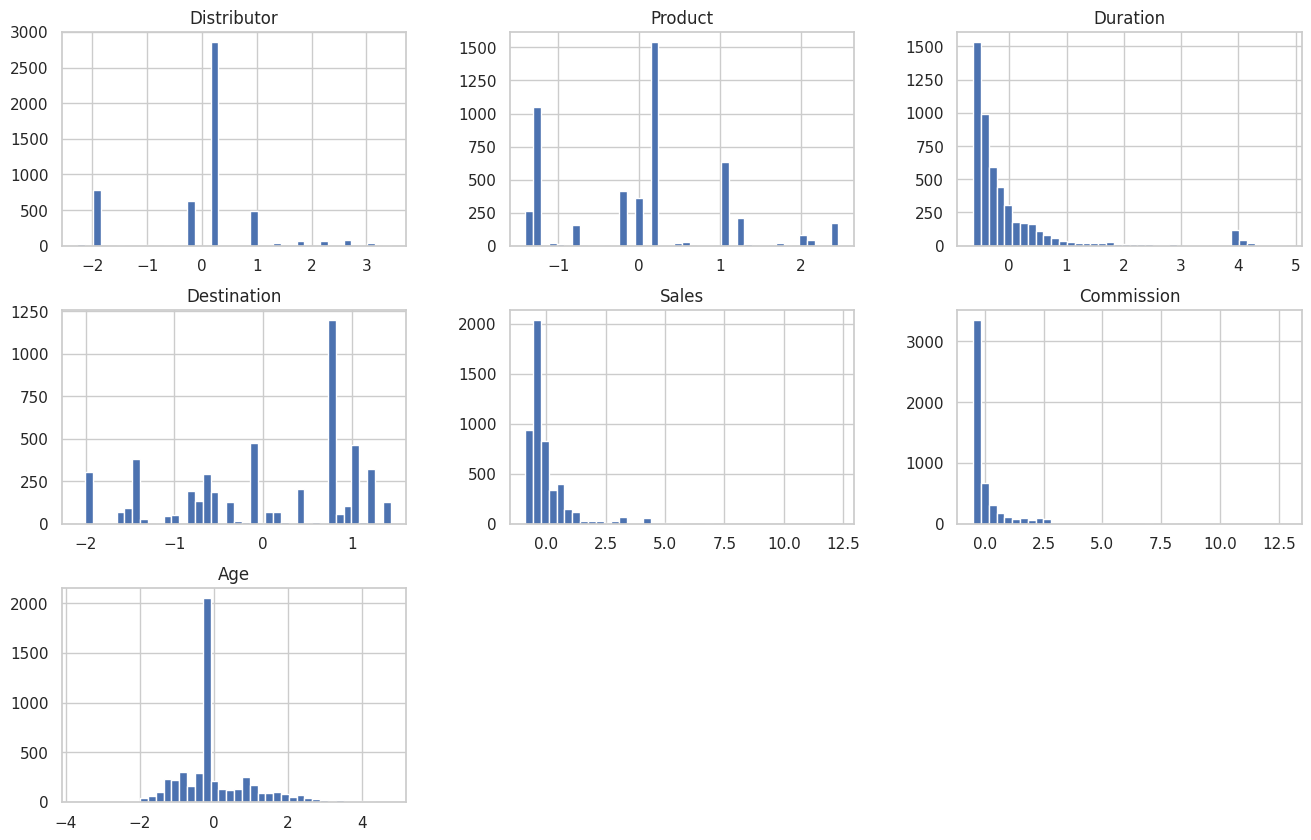

In [39]:
pd.DataFrame(data=X_train_resc, columns=features).hist(bins=40, figsize=(16,10));
# Try different aproaches for Duration, Sales and Commission --> some power transform

In [27]:
y_pred = clf.predict(X=X_val[features])

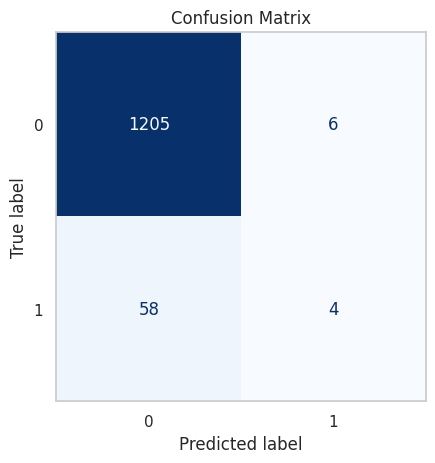

In [28]:
ax = plt.subplot()
cm = confusion_matrix(y_true=y_val, y_pred=y_pred)
ConfusionMatrixDisplay.from_predictions(y_true=y_val, y_pred=y_pred, ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
ax.grid(False)

In [30]:
print(classification_report(y_pred=y_pred, y_true=y_val, digits=4))

              precision    recall  f1-score   support

           0     0.9541    0.9950    0.9741      1211
           1     0.4000    0.0645    0.1111        62

    accuracy                         0.9497      1273
   macro avg     0.6770    0.5298    0.5426      1273
weighted avg     0.9271    0.9497    0.9321      1273



In [33]:
# Feature importance
importance = pd.DataFrame({
    'feature': features,
    'importance': clf.named_steps['model'].feature_importances_
}).sort_values('importance', ascending=False)
print("\
Feature Importance:")
print(importance)

Feature Importance:
       feature  importance
2     Duration    0.292919
6          Age    0.239108
4        Sales    0.182832
5   Commission    0.121644
3  Destination    0.063741
0  Distributor    0.059433
1      Product    0.040322


In [31]:
len(y_train[y_train==0]) / len(y_train[y_train==1])

19.449799196787147